# Assignment 4

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

This assignment requires that you to find **at least** two datasets on the web which are related, and that you visualize these datasets to answer a question with the broad topic of **economic activity or measures** (see below) for the region of **Farmington, Michigan, United States**, or **United States** more broadly.

You can merge these datasets with data from different regions if you like! For instance, you might want to compare **Farmington, Michigan, United States** to Ann Arbor, USA. In that case at least one source file must be about **Farmington, Michigan, United States**.

You are welcome to choose datasets at your discretion, but keep in mind **they will be shared with your peers**, so choose appropriate datasets. Sensitive, confidential, illicit, and proprietary materials are not good choices for datasets for this assignment. You are welcome to upload datasets of your own as well, and link to them using a third party repository such as github, bitbucket, pastebin, etc. Please be aware of the Coursera terms of service with respect to intellectual property.

Also, you are welcome to preserve data in its original language, but for the purposes of grading you should provide english translations. You are welcome to provide multiple visuals in different languages if you would like!

As this assignment is for the whole course, you must incorporate principles discussed in the first week, such as having as high data-ink ratio (Tufte) and aligning with Cairo’s principles of truth, beauty, function, and insight.

Here are the assignment instructions:

 * State the region and the domain category that your data sets are about (e.g., **Farmington, Michigan, United States** and **economic activity or measures**).
 * You must state a question about the domain category and region that you identified as being interesting.
 * You must provide at least two links to available datasets. These could be links to files such as CSV or Excel files, or links to websites which might have data in tabular form, such as Wikipedia pages.
 * You must upload an image which addresses the research question you stated. In addition to addressing the question, this visual should follow Cairo's principles of truthfulness, functionality, beauty, and insightfulness.
 * You must contribute a short (1-2 paragraph) written justification of how your visualization addresses your stated research question.

What do we mean by **economic activity or measures**?  For this category you might look at the inputs or outputs to the given economy, or major changes in the economy compared to other regions.

## Tips
* Wikipedia is an excellent source of data, and I strongly encourage you to explore it for new data sources.
* Many governments run open data initiatives at the city, region, and country levels, and these are wonderful resources for localized data sources.
* Several international agencies, such as the [United Nations](http://data.un.org/), the [World Bank](http://data.worldbank.org/), the [Global Open Data Index](http://index.okfn.org/place/) are other great places to look for data.
* This assignment requires you to convert and clean datafiles. Check out the discussion forums for tips on how to do this from various sources, and share your successes with your fellow students!

## Example
Looking for an example? Here's what our course assistant put together for the **Ann Arbor, MI, USA** area using **sports and athletics** as the topic. [Example Solution File](./readonly/Assignment4_example.pdf)

<IPython.core.display.Javascript object>


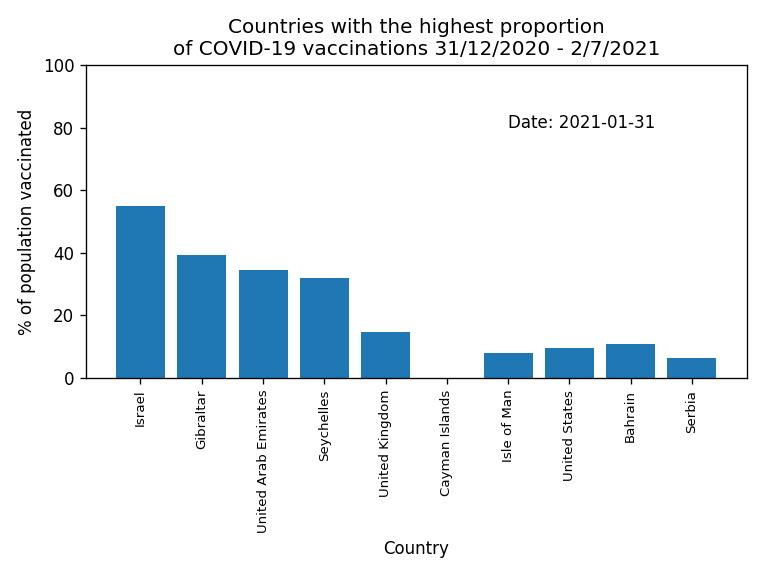

In [46]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt

#################################################################################

def __init_plot(plt):
    plt.cla()
    plt.ylabel('% of population vaccinated')
    plt.xlabel('Country')
    plt.ylim((0, 100))
    plt.xticks(np.arange(0, TOP_N))
    plt.gca().set_xticklabels(list(top_n.columns), rotation=90)
    plt.gca().tick_params(axis='x', which='major', labelsize=8)
    plt.gca().set_title(
        'Countries with the highest proportion\nof COVID-19 vaccinations 31/12/2020 - 2/7/2021'
    )

#################################################################################

def update(curr):
    if curr[1] == len(dates_to_be_displayed):
        a.event_source.stop()
    __init_plot(plt)
    plt.bar(np.arange(0, TOP_N), top_n.iloc[curr[1]] / top_n.loc['total_population'] * 100)
    plt.text(6, 80, 'Date: {}'.format(curr[0]))
    plt.tight_layout()

#################################################################################

LOCATIONS = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/locations.csv'
COUNTRY_DATA = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/country_data/{}.csv'
POPULATION_DATA = 'https://raw.githubusercontent.com/datasets/population/master/data/population.csv'

SPACE = '%20'

DATE_COLUMN = 'date'
TOTAL_VAX_COLUMN = 'total_vaccinations'
TOTAL_POPULATION_COLUMN = 'total_population'
COUNTRY_NAME_COLUMN = 'Country Name'
PROPORTION_COLUMN = 'prop'

REGEX_COLUMNS_TO_KEEP = 'date|total_vaccinations'
START_DATE = '31/12/2020'
END_DATE = '2/7/2021'
TOP_N = 10

#################################################################################

# get countries for which data is available
countries = pd.read_csv(LOCATIONS).location

# start and end dates for the visualization
date_range = pd.date_range(start=START_DATE, end=END_DATE)

# read csv for each country (data available in the same repo)
countrywise_vaccinations = {
    country: pd.read_csv(
        COUNTRY_DATA.format(country.replace(' ', SPACE)),
        parse_dates=[DATE_COLUMN],
        index_col=DATE_COLUMN,
    )
    # pick required columns, we only need date and total_vaccinations here 
    .filter(regex=REGEX_COLUMNS_TO_KEEP)
    # fill values that are not available with 0s
    .fillna(0)
    # if data is not available for certain dates, create a row for it anyway and initialize it with 0
    .reindex(date_range, fill_value=0)
    for country in countries
}

# convert this data into a DataFrame. there is probably a better way to do this :/
df_countrywise_vaccinations = pd.DataFrame({}, columns=date_range)
for country in countries:
    df_countrywise_vaccinations = df_countrywise_vaccinations.append(
        countrywise_vaccinations[country].rename(columns={TOTAL_VAX_COLUMN: country}).transpose()
    )

# get population data. filter out old data; keep the latest
latest_country_populations = (
    pd.read_csv(
        POPULATION_DATA
    )
    .groupby([COUNTRY_NAME_COLUMN])
    .tail(1)
).set_index(COUNTRY_NAME_COLUMN)

# add this total population info in a column in our DF
df_countrywise_vaccinations[TOTAL_POPULATION_COLUMN] = df_countrywise_vaccinations.apply(
    lambda row: latest_country_populations.loc[row.name].Value
    if row.name in latest_country_populations.index
    else 1,
    axis=1,
)

# filter out countries where total population data is not available
df_countrywise_vaccinations = df_countrywise_vaccinations[df_countrywise_vaccinations[TOTAL_POPULATION_COLUMN] != 1]

# calculate the proportion of vaccinated population using total population and highest number of total vaccinations (which is also the latest)
df_countrywise_vaccinations[PROPORTION_COLUMN] = (df_countrywise_vaccinations.iloc[:, :-1].max(axis=1)) / (df_countrywise_vaccinations.iloc[:, -1])

# sort DF in descending order of this proportion 
df_countrywise_vaccinations = df_countrywise_vaccinations.sort_values(by=PROPORTION_COLUMN, ascending=False)

# get only the top 10 countries
top_n = df_countrywise_vaccinations.head(10).transpose()

# convert date into a presentable format
dates_to_be_displayed = list(
    map(
        lambda x: str(x).split(' ')[0],
        list(date_range),
    )
)

fig = plt.figure()


# in the DF, fill 0s with previous day's value. 0 indicates no data is available, so consider the latest available value
top_n = top_n.apply(lambda x: x.replace(to_replace=0, method='ffill'), axis=0)[:-1]

a = animation.FuncAnimation(
    fig, update, frames=list(zip(dates_to_be_displayed, np.arange(0, len(dates_to_be_displayed)))), interval=500
)

